# Note
All the code inside this notebook has been adapted from two notebooks aviable online at: https://github.com/kylewest520/CS-7641---Machine-Learning/tree/master/Assignment%201%20Supervised%20Learning and https://github.com/niranjantdesai/cs-7641-machine-learning/tree/master/assgn1-supervised_learning

In [1]:
#from load_data import load_breast_cancer_data, load_mushroom_data, load_wine_quality_data

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import importlib
import random
import time
import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Data loading and preprocessing
Let's load the data, standardize it and split it into training and test sets.
This dataset has been built from the combination of the FIFA ranking dataset available at https://www.kaggle.com/tadhgfitzgerald/fifa-international-soccer-mens-ranking-1993now and the international football results dataset from: https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017

In [2]:

file = r".\footballdataset.csv"

def load_football_data(filename):
    """
    Loads the Football dataset 
    :param filename: path to csv file
    :return: X (data) and y (labels)
    """

    data = pd.read_csv(filename,delimiter=";")
    # y includes our labels and x includes our features
    y = data.result # win  lose or draw
    # we drop: "Result" as it is the label, "home_score" and "away_score" since it gives the result, "country" 
    # and "city" where removed since we already know if the game is played in a neutral stadium thanks to the boolean feature 
    #neutral. Moreover, "city" and "country" has a lot of possible 
    to_drop = ['date','result','city','country','home_score','away_score']
    
    X = data.drop(to_drop, axis=1)

#We remove the features of non ranked teams    
    rank_away=X.rank_away.values
    rank_home=X.rank_home.values
    X=X.values
    y = y.values
    
    A=[]
    B=[]
    for i in range(len(X)):
        if rank_away[i]!=0 and rank_home[i]!=0:
            A.append(X[i])
            B.append(y[i])
    X=np.array(A)  
    y=np.array(B)
    
    # We convert y into a boolean variable, since our goal is to dertermine wether or not the home_team will win.
    
    for i in range (len(y)):
        if y[i]<=0:
            y[i]=0
    y = y.astype(int)
    return X, y

X,y = load_football_data(file)
print(X[0:3])

[[1993 'Bolivia' 'Uruguay' 'FIFA World Cup qualification' 0 1.4 1.2 1.0
  1.1 -0.1 0.1 22 59]
 [1993 'Brazil' 'Mexico' 'Friendly' 0 1.7 3.7 1.1 0.6 0.1 0.6 14 8]
 [1993 'Ecuador' 'Venezuela' 'FIFA World Cup qualification' 0 1.5 1.0 0.7
  2.8 0.2 -0.5 94 35]]


# Pre-proccessing
We preprocess the data by a label encoding of the string features. I chose a label encoding and not a one hot encoding not to increase too much the size of the vetors representing the variables. In fact, there are more than 350 home teams and as much away teams.
After the label encoding, we standardize the data, and split it into a train set and a test set.

In [3]:
#Pre-processing (labelEncoding)
X_foot=X.copy()
labelencoder = LabelEncoder()
X_foot[:, 1] = labelencoder.fit_transform(X_foot[:, 1])
X_foot[:, 2] = labelencoder.fit_transform(X_foot[:, 2])
X_foot[:, 3] = labelencoder.fit_transform(X_foot[:, 3])

X=X_foot

print('Total number of examples in the dataset: %d' % X.shape[0])
print('Fraction of positive examples: %.2f%%' % (y[y == 1].shape[0]/y.shape[0]*100.0))

# Standardize data
X = preprocessing.scale(X)

# Split into training and test data. Use random_state to get the same results in every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=18)

# Data structures for storing best accuracies, training time and test time
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

Total number of examples in the dataset: 16310
Fraction of positive examples: 48.45%


The fraction of positive examples suggests that our data is balanced.

#  Helper Functions


In [72]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit

def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Accuracy")
    plt.fill_between(train_sizes, train_mean - 0.5*train_std, train_mean + 0.5*train_std, alpha=0.1, color="royalblue")
    plt.fill_between(train_sizes, cv_mean - 0.5*cv_std, cv_mean + 0.5*cv_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_mean, 'o-', color="royalblue", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="orange", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 0.5*fit_std, fit_mean + 0.5*fit_std, alpha=0.1, color="royalblue")
    plt.fill_between(train_sizes, pred_mean - 0.5*pred_std, pred_mean + 0.5*pred_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, fit_mean, 'o-', color="royalblue", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="orange", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


# Decision tree
Let's first train a decision tree without any optimization to get a feel for its performance on the given data.

In [156]:
clf_dt = tree.DecisionTreeClassifier(random_state=7)
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree without hyperparameter tuning is %.2f%%' % (dt_accuracy*100))
print(clf_dt.feature_importances_)

Accuracy of decision tree without hyperparameter tuning is 59.72%
[0.06252961 0.08493692 0.07518254 0.03452277 0.01315969 0.06975374
 0.06962401 0.07052368 0.07712415 0.04784594 0.05440863 0.16697488
 0.17341344]


## Validation curve
We will use a form of pre-pruning to prevent overfitting. Performance of a decision tree is affected by its maximum depth. A tree with a large depth will try to fit the training data exactly and is likely to result in overfitting. Let's plot the training and cross-validation scores to get a sense of how much the tree overfits with an increase in the depth.

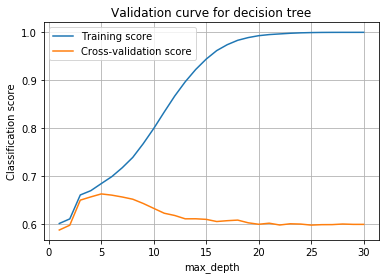

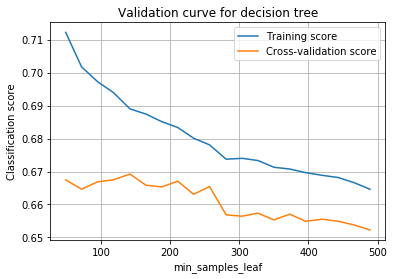

In [157]:
depth_range = np.arange(30)+1

train_scores, test_scores = validation_curve(clf_dt, X_train, y_train, param_name="max_depth", param_range=depth_range, cv=5,
                                            n_jobs=4)

plt.figure()
#plt.xticks(depth_range)
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()



start_leaf_n=round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train))
min_samples_leaf_range=np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int')

train_scores, test_scores = validation_curve(clf_dt, X_train, y_train, param_name='min_samples_leaf', param_range=min_samples_leaf_range, cv=5,
                                            n_jobs=4)

plt.figure()
#plt.xticks(depth_range)
plt.plot(min_samples_leaf_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(min_samples_leaf_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('min_samples_leaf')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

For low values of max_depth, the tree is excessively pruned and thus suffers from underfitting as both the training and cross-validation scores are low. The training score keeps increasing as max_depth increases. However, the cross-validation score first increases but starts decreasing at a certain point and then plateaus. Thus, at higher values of max_depth, the tree starts to overfit.

## Hyperparameter tuning
Based on the validation curve above, we will define an appropriate grid for max_depth, tune it and find out the best accuracy using a decision tree.

In [158]:
tuned_params = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

clf_dt = GridSearchCV(clf_dt, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_dt.fit(X_train, y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_dt = clf_dt
best_dt_params = clf_dt.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)
t0 = time.time()
y_pred = clf_dt.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

Completed training in 11.167127 seconds
Best parameters set for decision tree found on development set:
{'max_depth': 7, 'min_samples_leaf': 142}
Inference time on test data: 0.000997 seconds
Accuracy of decision tree is 67.46%


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   11.41347
Model Prediction Time (s): 0.00066

F1 Score:  0.66
Accuracy:  0.67     AUC:       0.67
Precision: 0.68     Recall:    0.64
*****************************************************


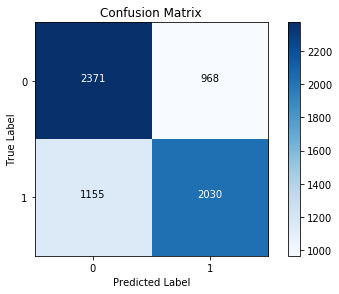

In [152]:
final_classifier_evaluation(clf_dt, X_train, X_test, y_train, y_test)

## Learning curve

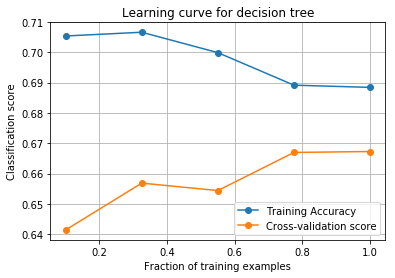

In [77]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_dt, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# Neural network
Due to computational complexity, we experimented with a small neural networks.The parameters we tuned are the number of units, the learning rate and the L2 penalty term alpha. We did this for several numbers of hidden layers, but this last parameters did not change the results drastically, so we kept the simple neural network with only one hidden layer.

In [65]:
nb_layers=1

def hyperNN(X_train, y_train, X_test, y_test, title):

    accuracy_test = []
    accuracy_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf_nn = MLPClassifier(hidden_layer_sizes=(i,nb_layers), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf_nn.fit(X_train, y_train)
            y_pred_test = clf_nn.predict(X_test)
            y_pred_train = clf_nn.predict(X_train)
            accuracy_test.append(accuracy_score(y_test, y_pred_test))
            accuracy_train.append(accuracy_score(y_train, y_pred_train))
            
      
    plt.plot(hlist, accuracy_test, 'o-', color='orange', label='Test Accuracy')
    plt.plot(hlist, accuracy_train, 'o-', color = 'royalblue', label='Train Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


The first parameter we tuned is the number of hidden units, then when tuned the learning rate and the L2 penalty term

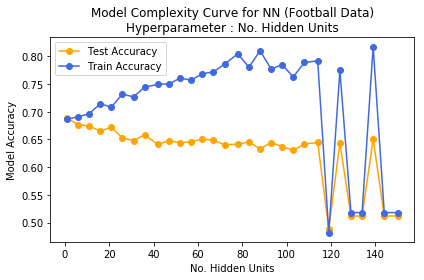

In [66]:
hyperNN(X_train, y_train, X_test, y_test,"Model Complexity Curve for NN (Football Data)\nHyperparameter : No. Hidden Units")


The figue above indicates that a neural network with 5 hidden units performs the best

In [103]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 1), random_state=7, max_iter=1000)
clf_nn.fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network of 1 layer and 5 hidden units without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network of 1 layer and 5 hidden units without hyperparameter tuning is 68.58%


## Validation curve
Let's plot validation curves to analyse the impact of the learning rate and alpha over the performances of our learner.

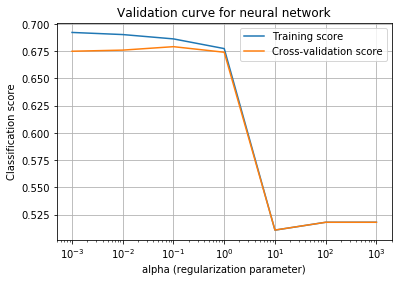

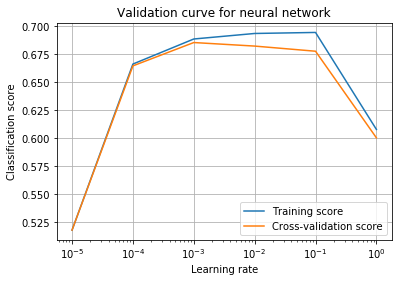

In [104]:
# Regularization parameter
alpha_range = np.logspace(-3, 3, 7)
clf_nn = MLPClassifier(hidden_layer_sizes=(5,nb_layers), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="alpha", param_range=alpha_range, cv=5, n_jobs=4)

plt.figure()
plt.semilogx(alpha_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(alpha_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('alpha (regularization parameter)')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Learning rate
lr_range = np.logspace(-5, 0, 6)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="learning_rate_init", param_range=lr_range, 
                                             cv=5, n_jobs=4)

plt.figure()
plt.semilogx(lr_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(lr_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('Learning rate')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_2.png')
plt.show()

## Hyperparameter tuning
Based on the validation curves plotted above, we will define an appropriate grid for each parameter and tune them.

In [105]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_nn.fit(X_train, y_train)
t1 = time.time()
train_time[1] = t1 - t0
print('Completed training in %f seconds' % train_time[1])
best_clf_nn = clf_nn
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Completed training in 56.086748 seconds
Best parameters set found on development set:
{'alpha': 0.1, 'learning_rate_init': 0.01}


## Loss curves
We will now observe how training error decreases with epochs.

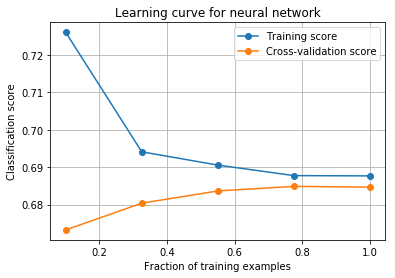

In [110]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(clf_nn, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for neural network')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

Accuracy of neural network is 69.25%


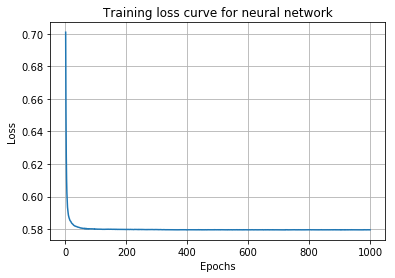

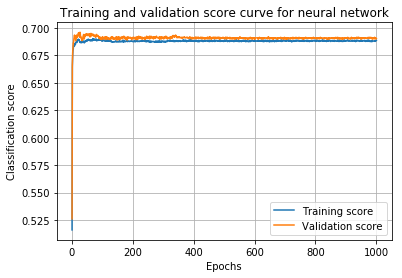

In [127]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 1), random_state=7, max_iter=1, warm_start=True)
clf_nn.set_params(alpha=best_params['alpha'], learning_rate_init=best_params['learning_rate_init'])
num_epochs = 1000
train_loss = np.empty(num_epochs)
train_scores = np.empty(num_epochs)
val_scores = np.empty(num_epochs)
# Split training set into training and validation
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=18)
for i in range(num_epochs):
    clf_nn.fit(X_train1, y_train1)
    train_loss[i] = clf_nn.loss_
    train_scores[i] = accuracy_score(y_train1, clf_nn.predict(X_train1))
    val_scores[i] = accuracy_score(y_val, clf_nn.predict(X_val))

y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network is %.2f%%' % (nn_accuracy * 100))

xrange = np.arange(num_epochs) + 1
plt.figure()
plt.plot(xrange, train_loss)
plt.title('Training loss curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.grid()
#plt.savefig(fig_path + 'nn_train_loss.png')
plt.show()

plt.figure()
plt.plot(xrange, train_scores, label='Training score')
plt.plot(xrange, val_scores, label='Validation score')
plt.title('Training and validation score curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Classification score")
plt.grid()
plt.legend(loc="best")
#plt.savefig(fig_path + 'nn_score_curve.png')
plt.show()


## Learning curve

## Evaluate optimal model
Let's find the test accuracy of the neural network with its hyperparameters tuned to their optimal values.

Best accuracy of neural network is 69.25%
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.03918
Model Prediction Time (s): 0.00185

F1 Score:  0.66
Accuracy:  0.69     AUC:       0.69
Precision: 0.70     Recall:    0.62
*****************************************************


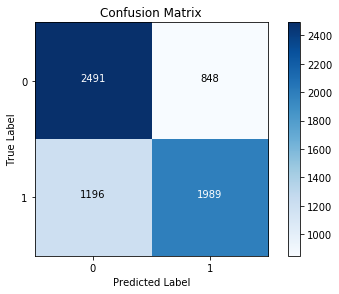

In [130]:
t0 = time.time()
y_pred = clf_nn.predict(X_test)
t1 = time.time()
test_time[1] = t1 - t0

best_accuracy[1] = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy[1] * 100))
final_classifier_evaluation(clf_nn, X_train, X_test, y_train, y_test)

# Boosting
We will use AdaBoost with decision stumps.

In [81]:
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, random_state=7)
clf_boosted.fit(X_train, y_train)
y_pred = clf_boosted.predict(X_test)
boosted_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost without hyperparameter tuning is %.2f%%' % (boosted_accuracy * 100))

Accuracy of Adaboost without hyperparameter tuning is 68.03%


## Validation curve
Number of weak learners is a hyperparameter we have to tune. To understand how it affects the performance of the classifier, we will plot training and cross-validation scores wrt the number of learners.

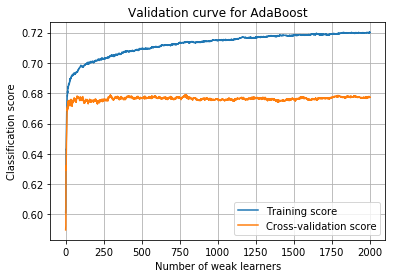

In [82]:
# Define AdaBoost learner
num_learners = 2000
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners, random_state=7)

# Cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=7)
train_scores = np.zeros((num_learners, num_folds))
val_scores = np.zeros((num_learners, num_folds))
for idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    clf_boosted.fit(X_train[train_index], y_train[train_index])
    train_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[train_index], y_train[train_index])))
    val_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[test_index], y_train[test_index])))

n_estimators_range = np.arange(num_learners) + 1
plt.figure()
plt.plot(n_estimators_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_estimators_range, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for AdaBoost')
plt.xlabel('Number of weak learners')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

## Evaluate optimal model

In [83]:
num_learners_optimal = np.argmax(np.mean(val_scores, axis=1)) + 1
print('Optimal number of learners for AdaBoost: %d' % num_learners_optimal)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
t0 = time.time()
best_clf_boosted.fit(X_train, y_train)
t1 = time.time()
train_time[2] = t1 - t0
print('Completed training in %f seconds' % train_time[2])
t0 = time.time()
y_pred = best_clf_boosted.predict(X_test)
t1 = time.time()
test_time[2] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[2])
best_accuracy[2] = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost with the best hyperparameters is %.2f%%' % (best_accuracy[2] * 100))

Optimal number of learners for AdaBoost: 786
Completed training in 4.507190 seconds
Inference time on test data: 0.424951 seconds
Accuracy of Adaboost with the best hyperparameters is 68.19%


## Learning curve

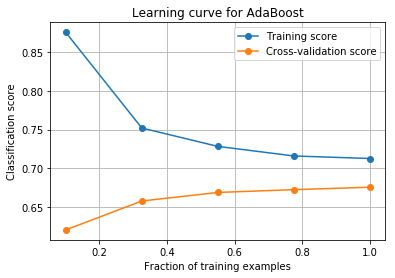

In [84]:
train_sizes = np.linspace(0.1, 1.0, 5)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
_, train_scores, test_scores = learning_curve(best_clf_boosted, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for AdaBoost')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# SVM
First let's determine the best kernel function for our problem

In [134]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    accuracy_test = []
    accuracy_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    accuracy_test.append(accuracy_score(y_test, y_pred_test))
                    accuracy_train.append(accuracy_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                accuracy_test.append(accuracy_score(y_test, y_pred_test))
                accuracy_train.append(accuracy_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, accuracy_test, 'o-', color='orange', label='Test Accuracy')
    plt.plot(xvals, accuracy_train, 'o-', color = 'royalblue', label='Train Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

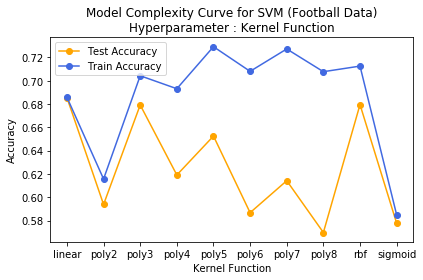

In [87]:
hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Football Data)\nHyperparameter : Kernel Function")

From the figure abuve, the best kernel function for this problem is a linear kernel

In [135]:
svm_linear = svm.SVC(kernel='linear', C=0.1)
svm_linear.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Validation curve
Let's plot the training and cross-validation scores wrt the penalty parameter $C$ (which controls regularization).

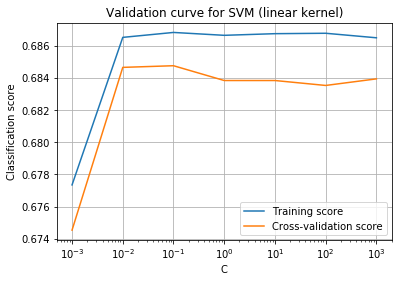

In [136]:
C_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(svm_linear, X_train, y_train, param_name="C", param_range=C_range, cv=5, n_jobs=4)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Hyperparameter tuning
Based on the validation curve plotted above, we will now define an appropriate grid for $C$ and tune it.

In [90]:
C_range = np.logspace(-2, 1, 10)
tuned_params = {'C' : C_range}
svm_linear = GridSearchCV(svm_linear, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
svm_linear.fit(X_train, y_train)
t1 = time.time()
train_time[3] = t1 - t0
print('Completed training in %f seconds' % train_time[3])
best_clf_svm = svm_linear
best_params = svm_linear.best_params_
print("Best parameters set found on development set:")
print(best_params)
t0 = time.time()
y_pred = best_clf_svm.predict(X_test)
t1 = time.time()
test_time[3] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[3])
best_accuracy[3] = accuracy_score(y_test, y_pred)
print('Best accuracy with SVM (linear kernel) is %.2f%%' % (best_accuracy[3] * 100))

Completed training in 104.259087 seconds
Best parameters set found on development set:
{'C': 0.1}
Inference time on test data: 0.529929 seconds
Best accuracy with SVM (linear kernel) is 68.53%


# Learning curve

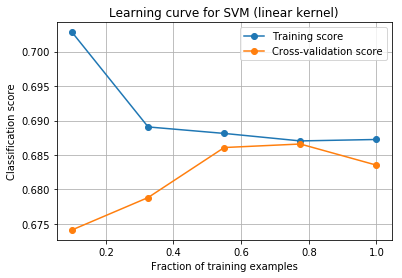

In [82]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_svm, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for SVM (linear kernel)')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.87823
Model Prediction Time (s): 0.45083

F1 Score:  0.66
Accuracy:  0.69     AUC:       0.68
Precision: 0.70     Recall:    0.62
*****************************************************


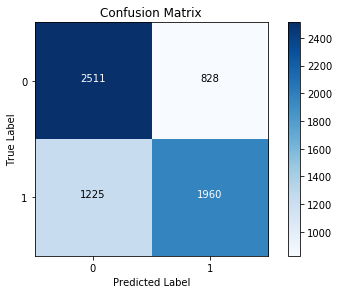

In [137]:
final_classifier_evaluation(svm_linear,X_train, X_test, y_train, y_test)

# kNN

## Validation curve
Let's find out how the accuracies are affected by the number of neighbors.

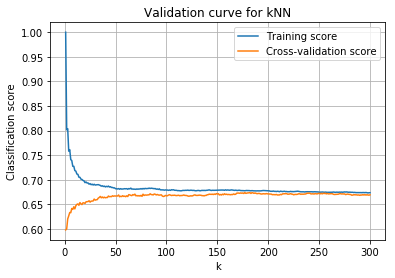

In [92]:
k_range = np.arange(1, 301)
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", 
                                             param_range=k_range, cv=5, n_jobs=4)

plt.figure()
plt.plot(k_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(k_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for kNN')
plt.xlabel('k')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

## Evaluate optimal model
We will choose the value of k which gives the best cross-validation score and evaluate test score with that.

In [93]:
k_optimal = np.argmax(np.mean(test_scores, axis=1)) + 1
print('Optimal value of k: %d' % k_optimal)
best_clf_knn = KNeighborsClassifier(n_neighbors=k_optimal)
t0 = time.time()
best_clf_knn.fit(X_train, y_train)
t1 = time.time()
train_time[4] = t1 - t0
print('Completed training in %f seconds' % train_time[4])
t0 = time.time()
y_pred = best_clf_knn.predict(X_test)
t1 = time.time()
test_time[4] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[4])
best_accuracy[4] = accuracy_score(y_test, y_pred)
print('Accuracy of kNN with k = %d is %.2f%%' % (k_optimal, best_accuracy[4] * 100))

Optimal value of k: 182
Completed training in 0.006980 seconds
Inference time on test data: 2.130031 seconds
Accuracy of kNN with k = 182 is 66.34%


## Learning curve

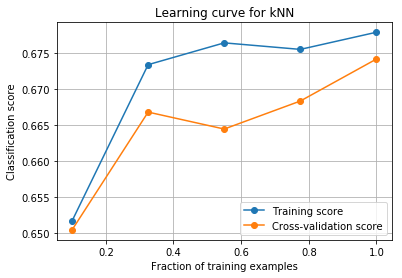

In [50]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_knn, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for kNN')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

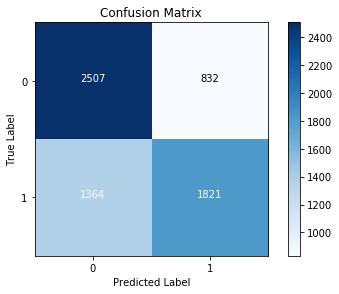

In [51]:
cm=confusion_matrix(y_test,y_pred)    
plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')

# Comparing the classifiers
We will now compare the 5 classifiers with respect to accuracy, training time and inference time

In [114]:
classifiers = ('Decision tree', 'Neural network', 'AdaBoost', 'SVM', 'kNN')
y_pos = np.arange(len(classifiers))

## Accuracy

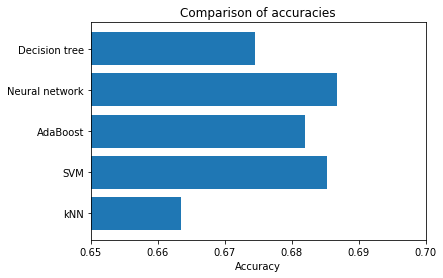

In [159]:
plt.figure()
plt.barh(y_pos, best_accuracy)
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.65, 0.7)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of accuracies')
plt.xlabel('Accuracy')
plt.show()

## Training time

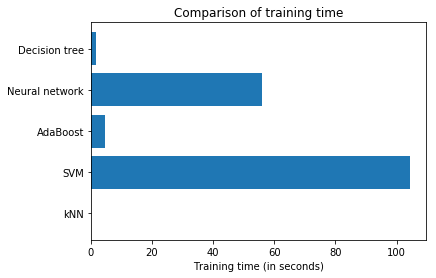

In [138]:
plt.figure()
plt.barh(y_pos, train_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of training time')
plt.xlabel('Training time (in seconds)')
plt.show()

## Inference time

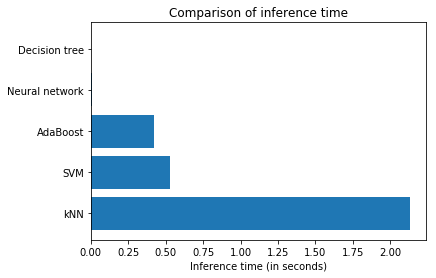

In [125]:
plt.figure()
plt.barh(y_pos, test_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of inference time')
plt.xlabel('Inference time (in seconds)')
plt.show()